
## Problem Statement

- Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
- Write a single notebook file to run all the 3 models above for 20 epochs each
- Create these graphs:
  Graph 1: Test/Validation Loss for all 3 models together
  Graph 2: Test/Validation Accuracy for 3 models together
  graphs must have proper annotation

- Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 

# Import Libraries

In [14]:
# import all the required torch functions
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from definitions import *


# Include Data Transformations

- We first start with defining our data transformations.
- We need to think what our data is and how can we augment it to represent  represent correctly which it might not see otherwise. 

In [15]:
# Train Phase transformations
train_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                            # Note the difference between (0.1307) and (0.1307,)
                        ])

# Test Phase transformations
test_transforms = transforms.Compose([
                            #  transforms.Resize((28, 28)),
                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])

# Dataset and Creating Train/Test Split

In [16]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Check for GPU availability

In [17]:
SEED = 1

# CUDA? Check for GPU availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# Setup Seed, for reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Dataloader Arguments & Test/Train Dataloaders

In [18]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model

- Let's import the model with configurable normalization layers incldued

In [19]:
from model import Net

# Check GPU Availability

In [20]:
# Once we have GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).
# test if PyTorch has access to a GPU
use_cuda = torch.cuda.is_available()

# if GPU is availble use it, if not use CPU. allocate device and assign n/w to it
device = torch.device("cuda" if use_cuda else "cpu")

# Model Summaries

In [21]:
!pip install torchsummary
from torchsummary import summary

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]

for norm in norm_options:
  
  print(f"\nModel Summary with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Check model summary
  summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Model Summary with NormalizationType => NormType.BATCH_NORM

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,080
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 15, 24, 24]             225
        MaxPool2d-10           [-1, 15, 12, 12]               0
           Conv2d-11           [-1, 15, 10, 10]           2,025
      

# Training and Testing

- Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 
- Let's write train and test functions

In [22]:
# define train & test APIs

# Tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):
  
  model.train() # set the model with training mode (this is the default mode)

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init. 
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict. 
    y_pred = model(data)

    # Calculate model prediction loss
    loss = F.nll_loss(y_pred, target)

    # Handle for L1 loss
    if RegularizerType.L1 == regularizer_type:
      l1 = 0
      for p in model.parameters():
        # absolute sum of all weights
        l1 += p.abs().sum()
      
      # Total loss is sum of model prediction loss + L1 loss
      loss += (regularizer_lambda * l1)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return 100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return 100. * correct / len(test_loader.dataset)


In [23]:
# Invoke train & evaluate the model 

from torch.optim.lr_scheduler import StepLR

def train_test_model(model, epochs=20, regularizer_lambda=0.01, regularizer_type=RegularizerType.NONE):

  # create an optimizer (SGD) with required parameters, 
  # model.parameters() - these are the model parameters to optimize, 
  # learning-rate lr=0.01 and momentum-0.9
  optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

  prev_train_acc = -1
  prev_test_acc = -1
  train_accuracy = 0
  test_accuracy = 0

  # run single epoch as of now.
  for epoch in range(epochs):
      print(f'Epoch: {epoch+1}')

      # train the model loaded on the device with the required optimizer
      train_accuracy = train(
                          model, device, train_loader, 
                          optimizer,
                          regularizer_lambda, 
                          regularizer_type)

      # set to the next lr params
      scheduler.step()

      # we need to evaluate on test data
      test_accuracy = test(model, device, test_loader)


      # check difference from previous accuracies for better understanding
      if -1 == prev_train_acc:
        prev_train_acc = train_accuracy
      if -1 == prev_test_acc:
        prev_test_acc = test_accuracy

      print(f'train_acc_diff: {train_accuracy - prev_train_acc:.3f} test_acc_diff: {test_accuracy - prev_test_acc:.3f} test_train_diff: {test_accuracy - train_accuracy:.3f}\n')
      prev_train_acc = train_accuracy
      prev_test_acc = test_accuracy

  # update model metric
  model_metric = [train_losses, test_losses, train_acc, test_acc]
  return model_metric

In [24]:
import copy

# Check all model Summaries
norm_options = [NormType.BATCH_NORM, NormType.LAYER_NORM, NormType.GROUP_NORM]
norm_name = ["BATCH_NORM", "LAYER_NORM", "GROUP_NORM"]

# evaluation metrics for different models
evaluation_metrics = {}
model_metric = []

print(f"\nTrain & Evaluate different model\n")

for ndx, norm in enumerate(norm_options):
  
  print(f"\nTrain & Test Model with NormalizationType => { norm }\n")
  
  # Create model instance with required params
  model = Net(norm_type=norm).to(device)

  # Map regularizer type as per the problem statement.
  regularizer = RegularizerType.NONE
  if NormType.BATCH_NORM == norm:
    regularizer = RegularizerType.NONE #To change to L1

  # reset to update metics for new model training
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # train the test model
  model_metric = train_test_model(
                        model, epochs=20, 
                        regularizer_lambda=0.01, 
                        regularizer_type=regularizer)

  # update final evaluation metrics for this model
  evaluation_metrics[norm_name[ndx]] = model_metric


Train & Evaluate different model


Train & Test Model with NormalizationType => NormType.BATCH_NORM

Epoch: 1


Loss=0.05957811698317528 Batch_id=468 Accuracy=92.33: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]



Test set: Average loss: 0.0944, Accuracy: 9696/10000 (96.96%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 4.635

Epoch: 2


Loss=0.017645055428147316 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0499, Accuracy: 9830/10000 (98.30%)

train_acc_diff: 5.542 test_acc_diff: 1.340 test_train_diff: 0.433

Epoch: 3


Loss=0.050121840089559555 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0362, Accuracy: 9887/10000 (98.87%)

train_acc_diff: 0.402 test_acc_diff: 0.570 test_train_diff: 0.602

Epoch: 4


Loss=0.10766615718603134 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0337, Accuracy: 9896/10000 (98.96%)

train_acc_diff: 0.163 test_acc_diff: 0.090 test_train_diff: 0.528

Epoch: 5


Loss=0.02859080582857132 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]



Test set: Average loss: 0.0337, Accuracy: 9895/10000 (98.95%)

train_acc_diff: 0.175 test_acc_diff: -0.010 test_train_diff: 0.343

Epoch: 6


Loss=0.07048401981592178 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:19<00:00, 23.65it/s]



Test set: Average loss: 0.0301, Accuracy: 9920/10000 (99.20%)

train_acc_diff: 0.047 test_acc_diff: 0.250 test_train_diff: 0.547

Epoch: 7


Loss=0.017610806971788406 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

train_acc_diff: 0.200 test_acc_diff: 0.020 test_train_diff: 0.367

Epoch: 8


Loss=0.06476177275180817 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)

train_acc_diff: 0.143 test_acc_diff: -0.070 test_train_diff: 0.153

Epoch: 9


Loss=0.06050502136349678 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]



Test set: Average loss: 0.0242, Accuracy: 9926/10000 (99.26%)

train_acc_diff: -0.065 test_acc_diff: 0.110 test_train_diff: 0.328

Epoch: 10


Loss=0.05415941774845123 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

train_acc_diff: 0.033 test_acc_diff: 0.000 test_train_diff: 0.295

Epoch: 11


Loss=0.06819178909063339 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

train_acc_diff: 0.062 test_acc_diff: -0.050 test_train_diff: 0.183

Epoch: 12


Loss=0.009240672923624516 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

train_acc_diff: 0.023 test_acc_diff: 0.060 test_train_diff: 0.220

Epoch: 13


Loss=0.019125111401081085 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

train_acc_diff: 0.068 test_acc_diff: 0.010 test_train_diff: 0.162

Epoch: 14


Loss=0.006671177688986063 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

train_acc_diff: 0.023 test_acc_diff: 0.070 test_train_diff: 0.208

Epoch: 15


Loss=0.021389247849583626 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

train_acc_diff: -0.027 test_acc_diff: 0.050 test_train_diff: 0.285

Epoch: 16


Loss=0.007922249846160412 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]



Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

train_acc_diff: -0.005 test_acc_diff: 0.010 test_train_diff: 0.300

Epoch: 17


Loss=0.07990499585866928 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

train_acc_diff: 0.050 test_acc_diff: -0.030 test_train_diff: 0.220

Epoch: 18


Loss=0.0035717871505767107 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

train_acc_diff: 0.027 test_acc_diff: -0.010 test_train_diff: 0.183

Epoch: 19


Loss=0.06603480875492096 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

train_acc_diff: 0.042 test_acc_diff: 0.040 test_train_diff: 0.182

Epoch: 20


Loss=0.017064468935132027 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

train_acc_diff: -0.037 test_acc_diff: -0.020 test_train_diff: 0.198


Train & Test Model with NormalizationType => NormType.LAYER_NORM

Epoch: 1


Loss=0.0791592076420784 Batch_id=468 Accuracy=90.09: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0745, Accuracy: 9807/10000 (98.07%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 7.978

Epoch: 2


Loss=0.0729893296957016 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0458, Accuracy: 9873/10000 (98.73%)

train_acc_diff: 7.570 test_acc_diff: 0.660 test_train_diff: 1.068

Epoch: 3


Loss=0.020070618018507957 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0341, Accuracy: 9897/10000 (98.97%)

train_acc_diff: 0.463 test_acc_diff: 0.240 test_train_diff: 0.845

Epoch: 4


Loss=0.036860838532447815 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

train_acc_diff: 0.192 test_acc_diff: 0.090 test_train_diff: 0.743

Epoch: 5


Loss=0.023939630016684532 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]



Test set: Average loss: 0.0292, Accuracy: 9911/10000 (99.11%)

train_acc_diff: 0.193 test_acc_diff: 0.050 test_train_diff: 0.600

Epoch: 6


Loss=0.018845295533537865 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0268, Accuracy: 9914/10000 (99.14%)

train_acc_diff: 0.065 test_acc_diff: 0.030 test_train_diff: 0.565

Epoch: 7


Loss=0.06293252110481262 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.10%)

train_acc_diff: 0.232 test_acc_diff: -0.040 test_train_diff: 0.293

Epoch: 8


Loss=0.035567089915275574 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0269, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.110 test_acc_diff: 0.150 test_train_diff: 0.333

Epoch: 9


Loss=0.031160905957221985 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0242, Accuracy: 9921/10000 (99.21%)

train_acc_diff: 0.000 test_acc_diff: -0.040 test_train_diff: 0.293

Epoch: 10


Loss=0.02867305465042591 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0243, Accuracy: 9930/10000 (99.30%)

train_acc_diff: 0.015 test_acc_diff: 0.090 test_train_diff: 0.368

Epoch: 11


Loss=0.017816318199038506 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

train_acc_diff: 0.077 test_acc_diff: -0.180 test_train_diff: 0.112

Epoch: 12


Loss=0.010300208814442158 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]



Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

train_acc_diff: -0.007 test_acc_diff: 0.200 test_train_diff: 0.318

Epoch: 13


Loss=0.04817372187972069 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

train_acc_diff: 0.085 test_acc_diff: 0.020 test_train_diff: 0.253

Epoch: 14


Loss=0.01770428940653801 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

train_acc_diff: 0.015 test_acc_diff: 0.020 test_train_diff: 0.258

Epoch: 15


Loss=0.031939659267663956 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0221, Accuracy: 9936/10000 (99.36%)

train_acc_diff: -0.005 test_acc_diff: 0.000 test_train_diff: 0.263

Epoch: 16


Loss=0.03275141492486 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

train_acc_diff: 0.050 test_acc_diff: -0.060 test_train_diff: 0.153

Epoch: 17


Loss=0.0076120453886687756 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]



Test set: Average loss: 0.0194, Accuracy: 9946/10000 (99.46%)

train_acc_diff: 0.025 test_acc_diff: 0.160 test_train_diff: 0.288

Epoch: 18


Loss=0.02303861826658249 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 27.59it/s]



Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

train_acc_diff: -0.035 test_acc_diff: -0.070 test_train_diff: 0.253

Epoch: 19


Loss=0.0476355142891407 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

train_acc_diff: 0.095 test_acc_diff: -0.010 test_train_diff: 0.148

Epoch: 20


Loss=0.036755193024873734 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]



Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

train_acc_diff: -0.052 test_acc_diff: -0.010 test_train_diff: 0.190


Train & Test Model with NormalizationType => NormType.GROUP_NORM

Epoch: 1


Loss=0.10445037484169006 Batch_id=468 Accuracy=88.87: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0627, Accuracy: 9820/10000 (98.20%)

train_acc_diff: 0.000 test_acc_diff: 0.000 test_train_diff: 9.327

Epoch: 2


Loss=0.1038723811507225 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0525, Accuracy: 9834/10000 (98.34%)

train_acc_diff: 8.338 test_acc_diff: 0.140 test_train_diff: 1.128

Epoch: 3


Loss=0.13072064518928528 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0387, Accuracy: 9868/10000 (98.68%)

train_acc_diff: 0.775 test_acc_diff: 0.340 test_train_diff: 0.693

Epoch: 4


Loss=0.022603437304496765 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0391, Accuracy: 9864/10000 (98.64%)

train_acc_diff: 0.162 test_acc_diff: -0.040 test_train_diff: 0.492

Epoch: 5


Loss=0.04341968894004822 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0302, Accuracy: 9912/10000 (99.12%)

train_acc_diff: 0.282 test_acc_diff: 0.480 test_train_diff: 0.690

Epoch: 6


Loss=0.007069737184792757 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]



Test set: Average loss: 0.0279, Accuracy: 9899/10000 (98.99%)

train_acc_diff: 0.010 test_acc_diff: -0.130 test_train_diff: 0.550

Epoch: 7


Loss=0.015152737498283386 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]



Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

train_acc_diff: 0.355 test_acc_diff: 0.270 test_train_diff: 0.465

Epoch: 8


Loss=0.028565051034092903 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)

train_acc_diff: 0.095 test_acc_diff: -0.050 test_train_diff: 0.320

Epoch: 9


Loss=0.024412378668785095 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0220, Accuracy: 9923/10000 (99.23%)

train_acc_diff: 0.007 test_acc_diff: 0.020 test_train_diff: 0.333

Epoch: 10


Loss=0.007563360035419464 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0256, Accuracy: 9911/10000 (99.11%)

train_acc_diff: 0.078 test_acc_diff: -0.120 test_train_diff: 0.135

Epoch: 11


Loss=0.08012125641107559 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

train_acc_diff: -0.003 test_acc_diff: 0.150 test_train_diff: 0.288

Epoch: 12


Loss=0.03026718832552433 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

train_acc_diff: -0.002 test_acc_diff: 0.020 test_train_diff: 0.310

Epoch: 13


Loss=0.005424035247415304 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

train_acc_diff: 0.138 test_acc_diff: 0.030 test_train_diff: 0.202

Epoch: 14


Loss=0.00811756867915392 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0190, Accuracy: 9930/10000 (99.30%)

train_acc_diff: 0.052 test_acc_diff: -0.010 test_train_diff: 0.140

Epoch: 15


Loss=0.03233138844370842 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

train_acc_diff: -0.100 test_acc_diff: 0.150 test_train_diff: 0.390

Epoch: 16


Loss=0.0067556933499872684 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

train_acc_diff: 0.072 test_acc_diff: -0.060 test_train_diff: 0.258

Epoch: 17


Loss=0.036339882761240005 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0192, Accuracy: 9925/10000 (99.25%)

train_acc_diff: 0.060 test_acc_diff: -0.140 test_train_diff: 0.058

Epoch: 18


Loss=0.040801752358675 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]



Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

train_acc_diff: -0.030 test_acc_diff: 0.120 test_train_diff: 0.208

Epoch: 19


Loss=0.008052781224250793 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0183, Accuracy: 9936/10000 (99.36%)

train_acc_diff: 0.078 test_acc_diff: -0.010 test_train_diff: 0.120

Epoch: 20


Loss=0.012767056934535503 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

train_acc_diff: 0.028 test_acc_diff: 0.050 test_train_diff: 0.142



# Plot the model's learning progress

- Plot training and test accuracies of all models

<ipython-input-25-d4840e90c6c3>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2, 1)
<ipython-input-25-d4840e90c6c3>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


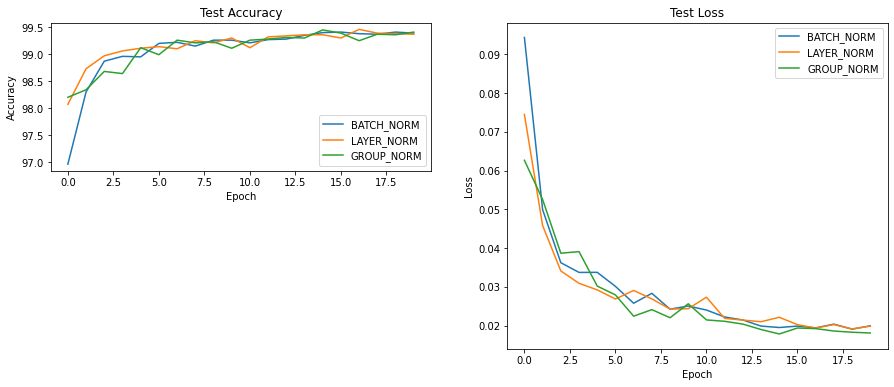

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

for name in norm_name:
  
  train_losses  = evaluation_metrics[name][0]
  test_losses   = evaluation_metrics[name][1]
  train_acc     = evaluation_metrics[name][2]
  test_acc      = evaluation_metrics[name][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_name)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_name)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


# Move tesnors to numpy as required

- train_losses is a list, but train_losses[i] is a tensor
- all others are numpy

## APIs to use

- To go from np.array to cpu Tensor    => torch.from_numpy().
- To go from cpu Tensor to gpu Tensor  => .cuda()
- To go from a Tensor that requires_grad to one that does not => .detach() 
- To go from a gpu Tensor to cpu Tensor => .cpu()
- To gp from a cpu Tensor to np.array   => .numpy()